# Name: Nalet Meinen

# Assignment 3 ATML 2020

## Unsupervised Feature Learning and Transfer Learning

In many real world applications the amount of labelled training data will be very limited since it is expensive to obtain. Often you will have access to a large amount of unlabelled data however. In this assignment you will explore techniques to leverage large amounts of unlabelled data to learn image representations. These image representations can then be used for novel tasks (e.g., classification) via supervised transfer learning. If the number of labelled examples for the target task is small, unsupervised feature learning can substatially improve the performance on the target task.


### Data

In this assignment you are given two types of training sets: 
- **A large unlabelled training set:** This data will be used to learn a data representation with some unsupervised feature learning method of your choice.
- **A small labelled training set:** This data will be used to perform transfer learning where the previously learned representation is repurposed for image classification.


### Choose an Unsupervised Learning Task

You are free to choose any method to learn features in an unsupervised manner. Possible examples are:
- **Autoencoders:** You can learn features in the encoder of some variant of autoencoders (DAE, VAE, etc...).
- **GAN:** You can use generative adversarial training and transfer features of the discriminator.
- **Self-Supervised Learning:** You can use a pretext task where labels come "for free". Some simple examples are "Rotation Prediction" and "Examplar-CNN".



In [0]:
import numpy as np
import time
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path
import glob
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.utils as vutils
import torch.optim as optim
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn

In [2]:
!nvidia-smi

Mon May 18 14:04:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
if not os.path.isfile('data.zip'):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment3/data.zip" "data.zip"
    !unzip -qq data.zip

## Task 1: Prepare data for unsupervised pre-training, supervised transfer learning and evaluation

You should create four different datasets: 
1. unlabelled training set (optionally including self-supervised labels) 
2. labelled training set 
3. labelled validation set 
4. unlabelled test set (kaggle)

In [0]:
class ImageNetLimited(torch.utils.data.Dataset):
    """ImageNet Limited dataset."""
    
    def __init__(self, root_dir, transform, labelled=True, instances=1):
        data = []
        self.labelled = labelled
        self.transform = transform
        if labelled:
            root_dir = root_dir + "/**/*"
        else:
            root_dir = root_dir + "/*"

        for path in tqdm(glob.glob(root_dir)):

            _image = Image.open(path)
            
            for _ in range(instances):
                if labelled:
                    target = int(os.path.basename(os.path.dirname(path)))
                    data.append((_image,target))
                else:
                    data.append(_image)
        
        self.n = len(data)
        self.data = data

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if(self.labelled):
            return self.transform(self.data[idx][0]), self.data[idx][1]
        else:
            return self.transform(self.data[idx])
        

In [5]:
path_train_unlabelled = 'data_assignment3/train_unlabelled'
path_train_labelled = 'data_assignment3/train'
path_validation_labelled = 'data_assignment3/val'
path_test_unlabelled = 'data_assignment3/test'

_t_mean=[0.485, 0.456, 0.406]
_t_std=[0.229, 0.224, 0.225]

_transform = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

_transforms_train = transforms.Compose([
    transforms.RandomRotation([-45,45]),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.5),     
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.01, 0.05), ratio=(0.2, 5), value=0),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

_transforms_val = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

dataset_train_unlabelled = ImageNetLimited(path_train_unlabelled, _transform, labelled=False)
dataset_train_labelled = ImageNetLimited(path_train_labelled, _transforms_train, labelled=True, instances=10)
dataset_validation_labelled = ImageNetLimited(path_validation_labelled, _transforms_val, labelled=True)

100%|██████████| 2000/2000 [00:00<00:00, 15940.77it/s]


torch.Size([128, 3, 64, 64])
782


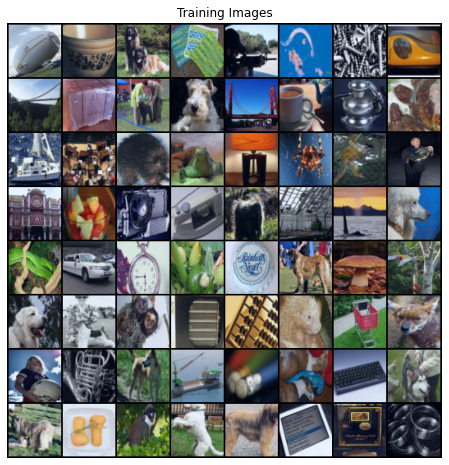

In [6]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

dataloader = torch.utils.data.DataLoader(dataset_train_unlabelled, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch.to(device).shape)
print(len(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Task 2: Define the CNN architecture

The architecture should be designed such that the first $k$ layers (the backbone) of the network are identical during unsupervised pre-training and supervised transfer learning. The remaining layers (the network head) can be different for unsupervised and supervised training.

Example: If you choose to train an autoencoder, the encoder layers would be shared between unsupervised pre-training and supervised transfer. The decoder layers would be removed and replaced by some number of fully-connected layers during transfer to classification.

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

shared01 = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True)
)
shared02 = nn.Sequential(
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True)
)
shared03 = nn.Sequential(
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True)
)
shared04 = nn.Sequential(
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True)
)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer01 = shared01
        self.layer02 = shared02
        self.layer03 = shared03
        self.layer04 = shared04
        self.layer05 = nn.Sequential(
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.layer01(input)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = self.layer05(output)
        return output

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.in_planes = 512

        self.layer01 = shared01
        self.layer02 = shared02
        self.layer03 = shared03
        self.layer04 = shared04
        self.classifier = nn.Sequential(
            nn.Dropout(0.8),
            nn.BatchNorm1d(512),
            nn.Linear(512, 200),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        output = self.layer01(input)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = nn.functional.avg_pool2d(output, 4)
        output = torch.flatten(output, 1)
        output = self.classifier(output)
        return output

print(Generator())
print(Discriminator())

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Task 3. Unsupervised Pre-Training
Implement the unsupervised training code for your model. You are not allowed to use a pre-trained model or labelled data (must train from scratch on the unlabelled training set). Monitor the performance on the pre-training task to check for convergence. Save the network parameters after pre-training (you will need them during transfer experiments).

In [8]:
# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 128, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for i, data in enumerate(dataloader):
        # maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        pbar.set_description('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                            % (i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        iters += 1

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

torch.save(netD.state_dict(), "unsuperviced_pre-training.pht")

[781/782]	Loss_D: 0.2737	Loss_G: 4.0299	D(x): 0.8067	D(G(z)): 0.0142 / 0.0346: 100%|██████████| 10/10 [12:34<00:00, 75.47s/it]


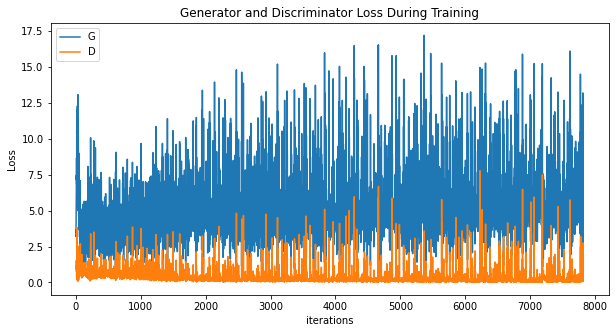

In [9]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

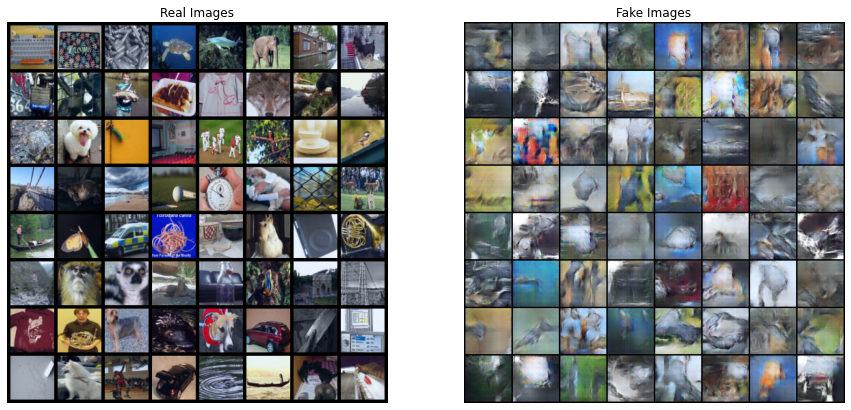

In [10]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Task 4. Transfer Learning Experiments

Perform the following set of transfer learning experiments:
- **Fixed Features:** Initialize the first $k$ layers with the parameters learned in Task 3 and randomly initialize the layers of the classification head. ***Train only the layers of the classification head!***
- **Finetuned Features:** Initialize the first $k$ layers with the parameters learned in Task 3 and randomly initialize the layers of the classification head. ***Train all the layers!***
- **Random Features Fixed:** Randomly initialize all the layers for the classification task (do not use parameters learned in Task 3). ***Train only the layers of the classification head!***
- **Random Features Finetuned:** Randomly initialize all the layers for the classification task (do not use parameters learned in Task 3). ***Train all the layers!***


Evaluate each of those models on the validation set and summarize the results in a Table. 

In [0]:
def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(taskname,train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        time.sleep(0.250) # needed for tqdm
        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))
        time.sleep(0.250)
        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

    best_model = ConvNet()
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch

def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

def test_pretrained(taskname,num_blocks,val_dataloader,loss_fn):
    best_model = ConvNet(num_blocks)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))
    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Model:", taskname, "Average loss:", m_loss, "Accuracy:", accuracy)

def show_validation_errors(taskname,num_blocks,test_loader,num_images=10):
    model = ConvNet(num_blocks)
    model = model.to(device)
    model.load_state_dict(torch.load(str(taskname)+".pht"))

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(_t_mean)
        std = np.array(_t_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.figure(figsize=(5,5))
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)
            
            for j in range(images.size()[0]):
                if(labels.cpu().data[j] == preds[j]):
                    continue
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('actual: {}, predicted: {}'.format(labels.cpu().data[j], preds[j]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    return

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy

In [12]:
def get_transfer_model(): 
    #Preparations
    pretrained_model = Discriminator()
    pretrained_model = pretrained_model.to(device)
    pretrained_model.load_state_dict(torch.load("unsuperviced_pre-training.pht"))

    #Transfer
    transfer_model = ConvNet()
    transfer_model.layer01 = pretrained_model.layer01
    transfer_model.layer02 = pretrained_model.layer02
    transfer_model.layer03 = pretrained_model.layer03
    transfer_model.layer04 = pretrained_model.layer04
    return transfer_model

train_dataloader = DataLoader(dataset_train_labelled, batch_size=batch_size, shuffle=True, num_workers=workers)
val_dataloader = DataLoader(dataset_validation_labelled, batch_size=batch_size, shuffle=False, num_workers=workers)
n_epochs = 50
loss_fn = nn.CrossEntropyLoss()

print(ConvNet())

ConvNet(
  (layer01): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer02): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer03): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer04): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (classifier): Sequential(
    (0): Drop

### Fixed Features


100%|██████████| 313/313 [00:22<00:00, 13.63it/s]


Epoch 1/50: train_loss: 5.3342, train_accuracy: 0.9200, val_loss: 5.1175, val_accuracy: 3.3000


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch 2/50: train_loss: 5.1734, train_accuracy: 1.6050, val_loss: 5.0241, val_accuracy: 3.4000


100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


Epoch 3/50: train_loss: 5.0838, train_accuracy: 2.1875, val_loss: 4.9706, val_accuracy: 3.4500


100%|██████████| 313/313 [00:22<00:00, 13.67it/s]


Epoch 4/50: train_loss: 5.0172, train_accuracy: 2.8425, val_loss: 4.9270, val_accuracy: 4.0500


100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


Epoch 5/50: train_loss: 4.9732, train_accuracy: 3.0850, val_loss: 4.8984, val_accuracy: 4.3500


100%|██████████| 313/313 [00:23<00:00, 13.51it/s]


Epoch 6/50: train_loss: 4.9439, train_accuracy: 3.2725, val_loss: 4.8711, val_accuracy: 4.6000


100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


Epoch 7/50: train_loss: 4.9046, train_accuracy: 3.6575, val_loss: 4.8515, val_accuracy: 4.4500


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch 8/50: train_loss: 4.8757, train_accuracy: 3.7050, val_loss: 4.8351, val_accuracy: 4.8500


100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


Epoch 9/50: train_loss: 4.8562, train_accuracy: 3.9900, val_loss: 4.8213, val_accuracy: 5.0500


100%|██████████| 313/313 [00:23<00:00, 13.46it/s]


Epoch 10/50: train_loss: 4.8482, train_accuracy: 3.9775, val_loss: 4.8082, val_accuracy: 4.8000


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


Epoch 11/50: train_loss: 4.8338, train_accuracy: 4.1925, val_loss: 4.7980, val_accuracy: 5.2000


100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


Epoch 12/50: train_loss: 4.8101, train_accuracy: 4.3475, val_loss: 4.7853, val_accuracy: 5.8000


100%|██████████| 313/313 [00:23<00:00, 13.51it/s]


Epoch 13/50: train_loss: 4.8029, train_accuracy: 4.5700, val_loss: 4.7764, val_accuracy: 5.5500


100%|██████████| 313/313 [00:23<00:00, 13.48it/s]


Epoch 14/50: train_loss: 4.7890, train_accuracy: 4.7075, val_loss: 4.7751, val_accuracy: 5.3000


100%|██████████| 313/313 [00:23<00:00, 13.46it/s]


Epoch 15/50: train_loss: 4.7873, train_accuracy: 4.4950, val_loss: 4.7685, val_accuracy: 5.5000


100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


Epoch 16/50: train_loss: 4.7779, train_accuracy: 4.5925, val_loss: 4.7586, val_accuracy: 5.6500


100%|██████████| 313/313 [00:23<00:00, 13.42it/s]


Epoch 17/50: train_loss: 4.7659, train_accuracy: 4.8750, val_loss: 4.7559, val_accuracy: 5.7500


100%|██████████| 313/313 [00:23<00:00, 13.43it/s]


Epoch 18/50: train_loss: 4.7558, train_accuracy: 4.9250, val_loss: 4.7495, val_accuracy: 5.8500


100%|██████████| 313/313 [00:23<00:00, 13.25it/s]


Epoch 19/50: train_loss: 4.7605, train_accuracy: 4.9825, val_loss: 4.7472, val_accuracy: 5.8000


100%|██████████| 313/313 [00:23<00:00, 13.42it/s]


Epoch 20/50: train_loss: 4.7471, train_accuracy: 5.0250, val_loss: 4.7434, val_accuracy: 5.9000


100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


Epoch 21/50: train_loss: 4.7496, train_accuracy: 4.8750, val_loss: 4.7433, val_accuracy: 5.6500


100%|██████████| 313/313 [00:23<00:00, 13.22it/s]


Epoch 22/50: train_loss: 4.7466, train_accuracy: 5.1275, val_loss: 4.7377, val_accuracy: 5.8500


100%|██████████| 313/313 [00:23<00:00, 13.40it/s]


Epoch 23/50: train_loss: 4.7346, train_accuracy: 5.1775, val_loss: 4.7388, val_accuracy: 5.7500


100%|██████████| 313/313 [00:23<00:00, 13.33it/s]


Epoch 24/50: train_loss: 4.7367, train_accuracy: 5.1100, val_loss: 4.7345, val_accuracy: 5.8500


100%|██████████| 313/313 [00:23<00:00, 13.27it/s]


Epoch 25/50: train_loss: 4.7343, train_accuracy: 5.0825, val_loss: 4.7326, val_accuracy: 5.9000


100%|██████████| 313/313 [00:23<00:00, 13.29it/s]


Epoch 26/50: train_loss: 4.7313, train_accuracy: 5.2025, val_loss: 4.7301, val_accuracy: 5.6500


100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


Epoch 27/50: train_loss: 4.7265, train_accuracy: 5.1900, val_loss: 4.7303, val_accuracy: 5.9000


100%|██████████| 313/313 [00:23<00:00, 13.23it/s]


Epoch 28/50: train_loss: 4.7311, train_accuracy: 5.3500, val_loss: 4.7253, val_accuracy: 5.6000


100%|██████████| 313/313 [00:23<00:00, 13.23it/s]


Epoch 29/50: train_loss: 4.7217, train_accuracy: 5.3275, val_loss: 4.7235, val_accuracy: 5.7500


100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


Epoch 30/50: train_loss: 4.7199, train_accuracy: 5.4250, val_loss: 4.7279, val_accuracy: 5.7000


100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Epoch 31/50: train_loss: 4.7166, train_accuracy: 5.3150, val_loss: 4.7177, val_accuracy: 6.1500


100%|██████████| 313/313 [00:23<00:00, 13.39it/s]


Epoch 32/50: train_loss: 4.7210, train_accuracy: 5.1850, val_loss: 4.7186, val_accuracy: 6.3000


100%|██████████| 313/313 [00:23<00:00, 13.39it/s]


Epoch 33/50: train_loss: 4.7153, train_accuracy: 5.3050, val_loss: 4.7171, val_accuracy: 6.3500


100%|██████████| 313/313 [00:23<00:00, 13.35it/s]


Epoch 34/50: train_loss: 4.7116, train_accuracy: 5.3950, val_loss: 4.7190, val_accuracy: 6.0000


100%|██████████| 313/313 [00:23<00:00, 13.34it/s]


Epoch 35/50: train_loss: 4.7156, train_accuracy: 5.4950, val_loss: 4.7180, val_accuracy: 5.8500


100%|██████████| 313/313 [00:23<00:00, 13.24it/s]


Epoch 36/50: train_loss: 4.7126, train_accuracy: 5.5000, val_loss: 4.7166, val_accuracy: 6.2500


100%|██████████| 313/313 [00:23<00:00, 13.40it/s]


Epoch 37/50: train_loss: 4.7139, train_accuracy: 5.1775, val_loss: 4.7130, val_accuracy: 6.2500


100%|██████████| 313/313 [00:23<00:00, 13.30it/s]


Epoch 38/50: train_loss: 4.7096, train_accuracy: 5.4175, val_loss: 4.7163, val_accuracy: 6.1500


100%|██████████| 313/313 [00:23<00:00, 13.29it/s]


Epoch 39/50: train_loss: 4.7107, train_accuracy: 5.5025, val_loss: 4.7150, val_accuracy: 6.2500


100%|██████████| 313/313 [00:23<00:00, 13.30it/s]


Epoch 40/50: train_loss: 4.7068, train_accuracy: 5.5125, val_loss: 4.7169, val_accuracy: 5.8000


100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Epoch 41/50: train_loss: 4.7071, train_accuracy: 5.5200, val_loss: 4.7125, val_accuracy: 5.8500


100%|██████████| 313/313 [00:23<00:00, 13.29it/s]


Epoch 42/50: train_loss: 4.7092, train_accuracy: 5.4200, val_loss: 4.7183, val_accuracy: 6.1000


100%|██████████| 313/313 [00:23<00:00, 13.32it/s]


Epoch 43/50: train_loss: 4.7037, train_accuracy: 5.4225, val_loss: 4.7158, val_accuracy: 6.2000


100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


Epoch 44/50: train_loss: 4.7104, train_accuracy: 5.2425, val_loss: 4.7162, val_accuracy: 6.0000


100%|██████████| 313/313 [00:23<00:00, 13.36it/s]


Epoch 45/50: train_loss: 4.7043, train_accuracy: 5.4325, val_loss: 4.7117, val_accuracy: 5.9500


100%|██████████| 313/313 [00:23<00:00, 13.46it/s]


Epoch 46/50: train_loss: 4.7100, train_accuracy: 5.3750, val_loss: 4.7124, val_accuracy: 6.0500


100%|██████████| 313/313 [00:23<00:00, 13.32it/s]


Epoch 47/50: train_loss: 4.7102, train_accuracy: 5.5900, val_loss: 4.7086, val_accuracy: 6.2000


100%|██████████| 313/313 [00:23<00:00, 13.05it/s]


Epoch 48/50: train_loss: 4.7085, train_accuracy: 5.3125, val_loss: 4.7029, val_accuracy: 6.2000


100%|██████████| 313/313 [00:24<00:00, 13.02it/s]


Epoch 49/50: train_loss: 4.7033, train_accuracy: 5.7275, val_loss: 4.7053, val_accuracy: 6.1500


100%|██████████| 313/313 [00:23<00:00, 13.12it/s]


Epoch 50/50: train_loss: 4.7103, train_accuracy: 5.4725, val_loss: 4.7113, val_accuracy: 6.0000


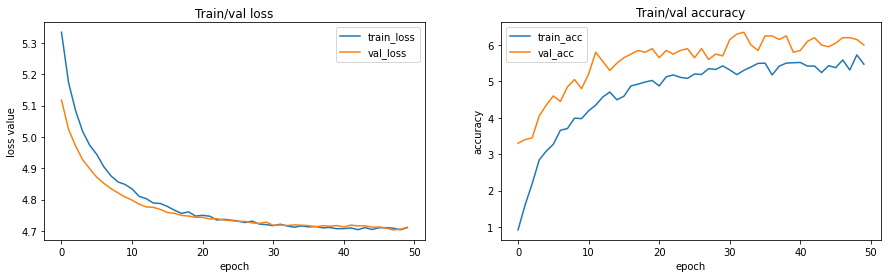

Best Epoch: 33 Average loss: 4.717105180025101 Accuracy: 6.35
CPU times: user 2min 54s, sys: 1min 22s, total: 4min 16s
Wall time: 20min 53s


In [13]:
%%time
model = ConvNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

model.layer01.requires_grad = False
model.layer02.requires_grad = False
model.layer03.requires_grad = False
model.layer04.requires_grad = False

optimizer = optim.Adam(model.classifier.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("fixed_features", train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_dataloader, val_dataloader)

### Finetuned Features


100%|██████████| 313/313 [00:24<00:00, 12.94it/s]


Epoch 1/50: train_loss: 5.1343, train_accuracy: 2.1025, val_loss: 4.8984, val_accuracy: 4.3500


100%|██████████| 313/313 [00:24<00:00, 12.86it/s]


Epoch 2/50: train_loss: 4.8135, train_accuracy: 4.0775, val_loss: 4.6968, val_accuracy: 6.4000


100%|██████████| 313/313 [00:24<00:00, 12.74it/s]


Epoch 3/50: train_loss: 4.6133, train_accuracy: 5.8075, val_loss: 4.6362, val_accuracy: 6.1000


100%|██████████| 313/313 [00:24<00:00, 12.79it/s]


Epoch 4/50: train_loss: 4.4732, train_accuracy: 7.2175, val_loss: 4.5782, val_accuracy: 7.1500


100%|██████████| 313/313 [00:24<00:00, 12.68it/s]


Epoch 5/50: train_loss: 4.3382, train_accuracy: 8.8575, val_loss: 4.5057, val_accuracy: 8.3500


100%|██████████| 313/313 [00:24<00:00, 12.88it/s]


Epoch 6/50: train_loss: 4.2336, train_accuracy: 9.9575, val_loss: 4.4166, val_accuracy: 9.2500


100%|██████████| 313/313 [00:24<00:00, 12.76it/s]


Epoch 7/50: train_loss: 4.1315, train_accuracy: 11.4825, val_loss: 4.4049, val_accuracy: 8.8000


100%|██████████| 313/313 [00:24<00:00, 12.82it/s]


Epoch 8/50: train_loss: 4.0382, train_accuracy: 12.8250, val_loss: 4.4829, val_accuracy: 8.9000


100%|██████████| 313/313 [00:24<00:00, 12.82it/s]


Epoch 9/50: train_loss: 3.9492, train_accuracy: 13.9200, val_loss: 4.3937, val_accuracy: 9.6000


100%|██████████| 313/313 [00:24<00:00, 12.87it/s]


Epoch 10/50: train_loss: 3.8664, train_accuracy: 14.8800, val_loss: 4.3295, val_accuracy: 10.1000


100%|██████████| 313/313 [00:23<00:00, 13.09it/s]


Epoch 11/50: train_loss: 3.7800, train_accuracy: 16.0925, val_loss: 4.3294, val_accuracy: 11.4000


100%|██████████| 313/313 [00:24<00:00, 13.01it/s]


Epoch 12/50: train_loss: 3.7139, train_accuracy: 17.3225, val_loss: 4.2897, val_accuracy: 11.6500


100%|██████████| 313/313 [00:24<00:00, 13.03it/s]


Epoch 13/50: train_loss: 3.6392, train_accuracy: 18.3650, val_loss: 4.2762, val_accuracy: 12.3500


100%|██████████| 313/313 [00:24<00:00, 12.92it/s]


Epoch 14/50: train_loss: 3.5725, train_accuracy: 19.6600, val_loss: 4.3650, val_accuracy: 11.8000


100%|██████████| 313/313 [00:24<00:00, 12.96it/s]


Epoch 15/50: train_loss: 3.5052, train_accuracy: 20.3725, val_loss: 4.3408, val_accuracy: 12.2500


100%|██████████| 313/313 [00:23<00:00, 13.09it/s]


Epoch 16/50: train_loss: 3.4381, train_accuracy: 21.4275, val_loss: 4.3098, val_accuracy: 11.9500


100%|██████████| 313/313 [00:24<00:00, 12.90it/s]


Epoch 17/50: train_loss: 3.3796, train_accuracy: 22.4600, val_loss: 4.3560, val_accuracy: 13.2000


100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Epoch 18/50: train_loss: 3.3182, train_accuracy: 23.6225, val_loss: 4.3029, val_accuracy: 13.5000


100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


Epoch 19/50: train_loss: 3.2556, train_accuracy: 24.6700, val_loss: 4.3982, val_accuracy: 12.7500


100%|██████████| 313/313 [00:23<00:00, 13.33it/s]


Epoch 20/50: train_loss: 3.2037, train_accuracy: 25.2600, val_loss: 4.2217, val_accuracy: 14.4500


100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


Epoch 21/50: train_loss: 3.1539, train_accuracy: 26.1900, val_loss: 4.3490, val_accuracy: 13.4000


100%|██████████| 313/313 [00:23<00:00, 13.40it/s]


Epoch 22/50: train_loss: 3.1037, train_accuracy: 26.8750, val_loss: 4.2555, val_accuracy: 14.1000


100%|██████████| 313/313 [00:23<00:00, 13.25it/s]


Epoch 23/50: train_loss: 3.0559, train_accuracy: 27.8375, val_loss: 4.3638, val_accuracy: 14.0000


100%|██████████| 313/313 [00:23<00:00, 13.45it/s]


Epoch 24/50: train_loss: 3.0180, train_accuracy: 28.3875, val_loss: 4.5099, val_accuracy: 12.7500


100%|██████████| 313/313 [00:23<00:00, 13.59it/s]


Epoch 25/50: train_loss: 2.9749, train_accuracy: 29.0800, val_loss: 4.3199, val_accuracy: 15.0000


100%|██████████| 313/313 [00:23<00:00, 13.45it/s]


Epoch 26/50: train_loss: 2.9152, train_accuracy: 30.4825, val_loss: 4.3269, val_accuracy: 14.2500


100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


Epoch 27/50: train_loss: 2.8918, train_accuracy: 30.7000, val_loss: 4.4924, val_accuracy: 12.8000


100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


Epoch 28/50: train_loss: 2.8444, train_accuracy: 31.7325, val_loss: 4.3730, val_accuracy: 14.6000


100%|██████████| 313/313 [00:23<00:00, 13.36it/s]


Epoch 29/50: train_loss: 2.7956, train_accuracy: 32.5050, val_loss: 4.3125, val_accuracy: 15.4000


100%|██████████| 313/313 [00:23<00:00, 13.61it/s]


Epoch 30/50: train_loss: 2.7653, train_accuracy: 33.1775, val_loss: 4.3416, val_accuracy: 14.4500


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch 31/50: train_loss: 2.7211, train_accuracy: 34.1150, val_loss: 4.3499, val_accuracy: 15.8000


100%|██████████| 313/313 [00:23<00:00, 13.51it/s]


Epoch 32/50: train_loss: 2.7004, train_accuracy: 34.0275, val_loss: 4.3541, val_accuracy: 15.3500


100%|██████████| 313/313 [00:23<00:00, 13.48it/s]


Epoch 33/50: train_loss: 2.6610, train_accuracy: 34.9825, val_loss: 4.4534, val_accuracy: 14.6500


100%|██████████| 313/313 [00:23<00:00, 13.52it/s]


Epoch 34/50: train_loss: 2.6280, train_accuracy: 35.4700, val_loss: 4.3931, val_accuracy: 15.1500


100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


Epoch 35/50: train_loss: 2.5943, train_accuracy: 36.0425, val_loss: 4.5279, val_accuracy: 15.6000


100%|██████████| 313/313 [00:23<00:00, 13.47it/s]


Epoch 36/50: train_loss: 2.5596, train_accuracy: 36.7650, val_loss: 4.4640, val_accuracy: 15.7000


100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


Epoch 37/50: train_loss: 2.5276, train_accuracy: 37.4650, val_loss: 4.4059, val_accuracy: 16.7500


100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


Epoch 38/50: train_loss: 2.4959, train_accuracy: 38.1150, val_loss: 4.4218, val_accuracy: 15.8000


100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


Epoch 39/50: train_loss: 2.4763, train_accuracy: 38.5000, val_loss: 4.4162, val_accuracy: 16.3500


100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


Epoch 40/50: train_loss: 2.4431, train_accuracy: 39.2050, val_loss: 4.4604, val_accuracy: 16.7500


100%|██████████| 313/313 [00:23<00:00, 13.59it/s]


Epoch 41/50: train_loss: 2.4183, train_accuracy: 39.7850, val_loss: 4.4033, val_accuracy: 15.9500


100%|██████████| 313/313 [00:23<00:00, 13.47it/s]


Epoch 42/50: train_loss: 2.3942, train_accuracy: 40.1475, val_loss: 4.5202, val_accuracy: 16.1000


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 43/50: train_loss: 2.3582, train_accuracy: 40.8925, val_loss: 4.4394, val_accuracy: 17.2500


100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


Epoch 44/50: train_loss: 2.3387, train_accuracy: 41.0525, val_loss: 4.5339, val_accuracy: 15.5000


100%|██████████| 313/313 [00:22<00:00, 13.69it/s]


Epoch 45/50: train_loss: 2.3165, train_accuracy: 41.6725, val_loss: 4.4754, val_accuracy: 17.1500


100%|██████████| 313/313 [00:22<00:00, 13.69it/s]


Epoch 46/50: train_loss: 2.2809, train_accuracy: 42.1275, val_loss: 4.4569, val_accuracy: 16.9000


100%|██████████| 313/313 [00:22<00:00, 13.80it/s]


Epoch 47/50: train_loss: 2.2532, train_accuracy: 42.9100, val_loss: 4.5426, val_accuracy: 15.8500


100%|██████████| 313/313 [00:22<00:00, 13.83it/s]


Epoch 48/50: train_loss: 2.2346, train_accuracy: 43.1475, val_loss: 4.5153, val_accuracy: 16.5000


100%|██████████| 313/313 [00:22<00:00, 13.82it/s]


Epoch 49/50: train_loss: 2.2051, train_accuracy: 44.1050, val_loss: 4.6037, val_accuracy: 15.7500


100%|██████████| 313/313 [00:22<00:00, 13.98it/s]


Epoch 50/50: train_loss: 2.1927, train_accuracy: 44.1600, val_loss: 4.6452, val_accuracy: 16.1000


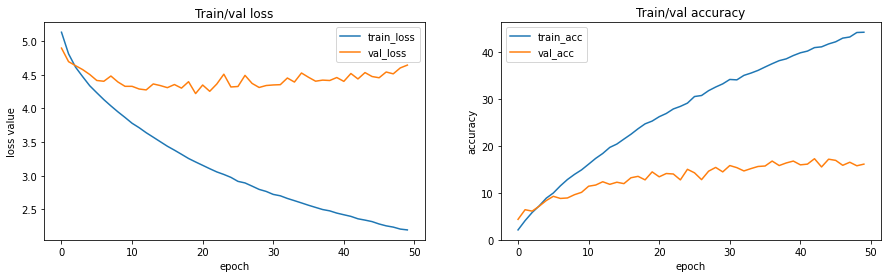

Best Epoch: 43 Average loss: 4.439444378018379 Accuracy: 17.25
CPU times: user 3min 11s, sys: 1min 11s, total: 4min 23s
Wall time: 20min 59s


In [14]:
%%time
#Preparations
model = ConvNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("finetuned_features", train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_dataloader, val_dataloader)

### Random Features Fixed


100%|██████████| 313/313 [00:22<00:00, 14.00it/s]


Epoch 1/50: train_loss: 5.0141, train_accuracy: 3.8025, val_loss: 4.7244, val_accuracy: 12.0000


100%|██████████| 313/313 [00:22<00:00, 13.90it/s]


Epoch 2/50: train_loss: 4.3042, train_accuracy: 13.5775, val_loss: 4.3577, val_accuracy: 15.5500


100%|██████████| 313/313 [00:22<00:00, 14.11it/s]


Epoch 3/50: train_loss: 3.7915, train_accuracy: 22.1850, val_loss: 4.1591, val_accuracy: 16.4000


100%|██████████| 313/313 [00:22<00:00, 13.99it/s]


Epoch 4/50: train_loss: 3.4294, train_accuracy: 27.8475, val_loss: 4.0338, val_accuracy: 16.7500


100%|██████████| 313/313 [00:22<00:00, 13.89it/s]


Epoch 5/50: train_loss: 3.1587, train_accuracy: 31.4875, val_loss: 3.9841, val_accuracy: 17.4500


100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch 6/50: train_loss: 2.9695, train_accuracy: 34.1225, val_loss: 3.9674, val_accuracy: 17.9000


100%|██████████| 313/313 [00:22<00:00, 14.18it/s]


Epoch 7/50: train_loss: 2.7998, train_accuracy: 36.5125, val_loss: 3.9756, val_accuracy: 18.0000


100%|██████████| 313/313 [00:22<00:00, 14.00it/s]


Epoch 8/50: train_loss: 2.7011, train_accuracy: 37.5225, val_loss: 3.9980, val_accuracy: 18.0500


100%|██████████| 313/313 [00:22<00:00, 13.94it/s]


Epoch 9/50: train_loss: 2.6025, train_accuracy: 38.7150, val_loss: 4.0324, val_accuracy: 18.1000


100%|██████████| 313/313 [00:22<00:00, 14.08it/s]


Epoch 10/50: train_loss: 2.5385, train_accuracy: 39.3375, val_loss: 4.0577, val_accuracy: 18.1500


100%|██████████| 313/313 [00:22<00:00, 14.20it/s]


Epoch 11/50: train_loss: 2.4849, train_accuracy: 40.2375, val_loss: 4.1000, val_accuracy: 18.0500


100%|██████████| 313/313 [00:22<00:00, 14.17it/s]


Epoch 12/50: train_loss: 2.4368, train_accuracy: 40.5300, val_loss: 4.1266, val_accuracy: 18.4000


100%|██████████| 313/313 [00:22<00:00, 14.13it/s]


Epoch 13/50: train_loss: 2.3988, train_accuracy: 41.3875, val_loss: 4.1652, val_accuracy: 18.5000


100%|██████████| 313/313 [00:22<00:00, 14.07it/s]


Epoch 14/50: train_loss: 2.3681, train_accuracy: 41.6000, val_loss: 4.2003, val_accuracy: 18.2500


100%|██████████| 313/313 [00:21<00:00, 14.32it/s]


Epoch 15/50: train_loss: 2.3378, train_accuracy: 42.1175, val_loss: 4.2400, val_accuracy: 18.4000


100%|██████████| 313/313 [00:22<00:00, 14.20it/s]


Epoch 16/50: train_loss: 2.3201, train_accuracy: 42.2800, val_loss: 4.2694, val_accuracy: 18.3500


100%|██████████| 313/313 [00:22<00:00, 14.16it/s]


Epoch 17/50: train_loss: 2.2925, train_accuracy: 42.5325, val_loss: 4.2706, val_accuracy: 18.4500


100%|██████████| 313/313 [00:21<00:00, 14.31it/s]


Epoch 18/50: train_loss: 2.2820, train_accuracy: 42.7900, val_loss: 4.2900, val_accuracy: 18.2000


100%|██████████| 313/313 [00:22<00:00, 14.06it/s]


Epoch 19/50: train_loss: 2.2668, train_accuracy: 42.9225, val_loss: 4.3364, val_accuracy: 18.7000


100%|██████████| 313/313 [00:22<00:00, 14.15it/s]


Epoch 20/50: train_loss: 2.2545, train_accuracy: 43.0350, val_loss: 4.3546, val_accuracy: 18.4500


100%|██████████| 313/313 [00:22<00:00, 14.21it/s]


Epoch 21/50: train_loss: 2.2370, train_accuracy: 43.0525, val_loss: 4.3906, val_accuracy: 18.8500


100%|██████████| 313/313 [00:21<00:00, 14.28it/s]


Epoch 22/50: train_loss: 2.2295, train_accuracy: 43.5225, val_loss: 4.3919, val_accuracy: 18.7500


100%|██████████| 313/313 [00:22<00:00, 14.09it/s]


Epoch 23/50: train_loss: 2.2298, train_accuracy: 43.5675, val_loss: 4.3781, val_accuracy: 18.5000


100%|██████████| 313/313 [00:22<00:00, 14.18it/s]


Epoch 24/50: train_loss: 2.2173, train_accuracy: 43.5800, val_loss: 4.4187, val_accuracy: 18.6000


100%|██████████| 313/313 [00:22<00:00, 14.09it/s]


Epoch 25/50: train_loss: 2.2231, train_accuracy: 43.5050, val_loss: 4.4276, val_accuracy: 18.3000


100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 26/50: train_loss: 2.2140, train_accuracy: 43.7375, val_loss: 4.4266, val_accuracy: 18.8000


100%|██████████| 313/313 [00:22<00:00, 14.10it/s]


Epoch 27/50: train_loss: 2.2001, train_accuracy: 43.8750, val_loss: 4.4723, val_accuracy: 18.6500


100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 28/50: train_loss: 2.2017, train_accuracy: 43.4525, val_loss: 4.4717, val_accuracy: 18.7500


100%|██████████| 313/313 [00:22<00:00, 13.97it/s]


Epoch 29/50: train_loss: 2.2066, train_accuracy: 43.4725, val_loss: 4.4424, val_accuracy: 18.7500


100%|██████████| 313/313 [00:22<00:00, 13.98it/s]


Epoch 30/50: train_loss: 2.2108, train_accuracy: 43.4925, val_loss: 4.4917, val_accuracy: 18.2500


100%|██████████| 313/313 [00:22<00:00, 14.05it/s]


Epoch 31/50: train_loss: 2.2050, train_accuracy: 43.2800, val_loss: 4.4823, val_accuracy: 18.4500


100%|██████████| 313/313 [00:22<00:00, 14.08it/s]


Epoch 32/50: train_loss: 2.1980, train_accuracy: 43.6150, val_loss: 4.5225, val_accuracy: 18.5500


100%|██████████| 313/313 [00:22<00:00, 13.90it/s]


Epoch 33/50: train_loss: 2.1993, train_accuracy: 43.7375, val_loss: 4.5235, val_accuracy: 18.6500


100%|██████████| 313/313 [00:22<00:00, 14.12it/s]


Epoch 34/50: train_loss: 2.1737, train_accuracy: 44.0200, val_loss: 4.4967, val_accuracy: 18.2000


100%|██████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch 35/50: train_loss: 2.1691, train_accuracy: 43.8850, val_loss: 4.5118, val_accuracy: 18.5000


100%|██████████| 313/313 [00:22<00:00, 13.89it/s]


Epoch 36/50: train_loss: 2.1913, train_accuracy: 43.4400, val_loss: 4.5320, val_accuracy: 18.3500


100%|██████████| 313/313 [00:22<00:00, 14.04it/s]


Epoch 37/50: train_loss: 2.1700, train_accuracy: 44.1450, val_loss: 4.5773, val_accuracy: 18.7500


100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch 38/50: train_loss: 2.1878, train_accuracy: 43.6300, val_loss: 4.5329, val_accuracy: 18.4500


100%|██████████| 313/313 [00:22<00:00, 13.82it/s]


Epoch 39/50: train_loss: 2.1740, train_accuracy: 44.1675, val_loss: 4.5538, val_accuracy: 18.1000


100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch 40/50: train_loss: 2.1766, train_accuracy: 44.0950, val_loss: 4.5446, val_accuracy: 18.1000


100%|██████████| 313/313 [00:22<00:00, 13.75it/s]


Epoch 41/50: train_loss: 2.1809, train_accuracy: 43.8975, val_loss: 4.5761, val_accuracy: 18.7000


100%|██████████| 313/313 [00:22<00:00, 13.94it/s]


Epoch 42/50: train_loss: 2.1653, train_accuracy: 44.1900, val_loss: 4.6023, val_accuracy: 18.3000


100%|██████████| 313/313 [00:22<00:00, 13.73it/s]


Epoch 43/50: train_loss: 2.1733, train_accuracy: 44.1625, val_loss: 4.5627, val_accuracy: 18.8500


100%|██████████| 313/313 [00:22<00:00, 13.85it/s]


Epoch 44/50: train_loss: 2.1723, train_accuracy: 44.1250, val_loss: 4.5944, val_accuracy: 18.4000


100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch 45/50: train_loss: 2.1826, train_accuracy: 43.5925, val_loss: 4.5982, val_accuracy: 18.7000


100%|██████████| 313/313 [00:22<00:00, 13.94it/s]


Epoch 46/50: train_loss: 2.1703, train_accuracy: 44.1350, val_loss: 4.6010, val_accuracy: 18.6500


100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch 47/50: train_loss: 2.1656, train_accuracy: 44.3575, val_loss: 4.6004, val_accuracy: 18.3500


100%|██████████| 313/313 [00:22<00:00, 14.08it/s]


Epoch 48/50: train_loss: 2.1788, train_accuracy: 43.9625, val_loss: 4.6373, val_accuracy: 18.3500


100%|██████████| 313/313 [00:22<00:00, 13.82it/s]


Epoch 49/50: train_loss: 2.1658, train_accuracy: 44.0650, val_loss: 4.6180, val_accuracy: 18.2000


100%|██████████| 313/313 [00:22<00:00, 13.96it/s]


Epoch 50/50: train_loss: 2.1838, train_accuracy: 43.6750, val_loss: 4.6113, val_accuracy: 18.6000


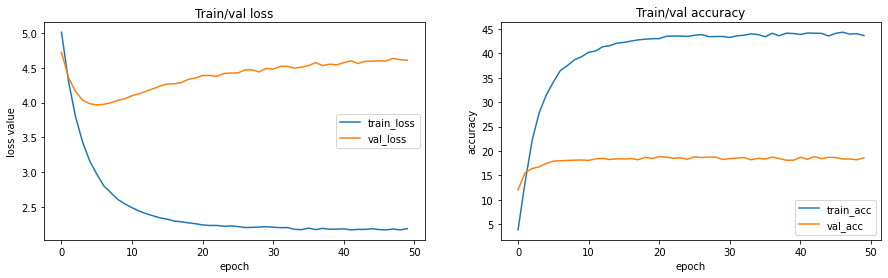

Best Epoch: 21 Average loss: 4.390562474727631 Accuracy: 18.85
CPU times: user 2min 51s, sys: 1min 20s, total: 4min 12s
Wall time: 19min 56s


In [15]:
%%time
model = ConvNet()
model = model.to(device)

model.layer01.requires_grad = False
model.layer02.requires_grad = False
model.layer03.requires_grad = False
model.layer04.requires_grad = False

optimizer = optim.Adam(model.classifier.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("random_features_fixed", train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_dataloader, val_dataloader)

### Random Features Finetuned


100%|██████████| 313/313 [00:22<00:00, 13.84it/s]


Epoch 1/50: train_loss: 4.8843, train_accuracy: 5.0100, val_loss: 4.6027, val_accuracy: 9.7000


100%|██████████| 313/313 [00:22<00:00, 13.85it/s]


Epoch 2/50: train_loss: 4.2354, train_accuracy: 13.1075, val_loss: 4.3423, val_accuracy: 12.3500


100%|██████████| 313/313 [00:22<00:00, 13.83it/s]


Epoch 3/50: train_loss: 3.8314, train_accuracy: 19.0100, val_loss: 4.1594, val_accuracy: 14.3500


100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


Epoch 4/50: train_loss: 3.5277, train_accuracy: 23.9200, val_loss: 4.0762, val_accuracy: 15.8000


100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


Epoch 5/50: train_loss: 3.2973, train_accuracy: 27.5975, val_loss: 4.0868, val_accuracy: 15.1000


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 6/50: train_loss: 3.0919, train_accuracy: 30.9400, val_loss: 4.0917, val_accuracy: 15.3500


100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


Epoch 7/50: train_loss: 2.9387, train_accuracy: 33.0450, val_loss: 3.9873, val_accuracy: 16.3500


100%|██████████| 313/313 [00:22<00:00, 13.63it/s]


Epoch 8/50: train_loss: 2.8133, train_accuracy: 35.4375, val_loss: 4.0362, val_accuracy: 17.1500


100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


Epoch 9/50: train_loss: 2.7036, train_accuracy: 36.8075, val_loss: 4.1133, val_accuracy: 15.7000


100%|██████████| 313/313 [00:22<00:00, 13.87it/s]


Epoch 10/50: train_loss: 2.6077, train_accuracy: 38.3775, val_loss: 4.1445, val_accuracy: 16.2000


100%|██████████| 313/313 [00:22<00:00, 13.70it/s]


Epoch 11/50: train_loss: 2.5403, train_accuracy: 39.2800, val_loss: 4.2152, val_accuracy: 15.9000


100%|██████████| 313/313 [00:23<00:00, 13.49it/s]


Epoch 12/50: train_loss: 2.4637, train_accuracy: 40.6725, val_loss: 4.1794, val_accuracy: 17.6000


100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


Epoch 13/50: train_loss: 2.3949, train_accuracy: 41.7825, val_loss: 4.2732, val_accuracy: 15.4000


100%|██████████| 313/313 [00:22<00:00, 13.70it/s]


Epoch 14/50: train_loss: 2.3328, train_accuracy: 43.0600, val_loss: 4.2693, val_accuracy: 16.9500


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch 15/50: train_loss: 2.2944, train_accuracy: 43.3475, val_loss: 4.2137, val_accuracy: 17.1500


100%|██████████| 313/313 [00:23<00:00, 13.39it/s]


Epoch 16/50: train_loss: 2.2455, train_accuracy: 44.3500, val_loss: 4.2846, val_accuracy: 17.0000


100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


Epoch 17/50: train_loss: 2.1998, train_accuracy: 45.2325, val_loss: 4.3001, val_accuracy: 16.5500


100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


Epoch 18/50: train_loss: 2.1714, train_accuracy: 45.4425, val_loss: 4.4377, val_accuracy: 16.1500


100%|██████████| 313/313 [00:23<00:00, 13.39it/s]


Epoch 19/50: train_loss: 2.1255, train_accuracy: 46.5875, val_loss: 4.4192, val_accuracy: 17.5000


100%|██████████| 313/313 [00:22<00:00, 13.71it/s]


Epoch 20/50: train_loss: 2.0974, train_accuracy: 47.0600, val_loss: 4.4089, val_accuracy: 16.2500


100%|██████████| 313/313 [00:23<00:00, 13.61it/s]


Epoch 21/50: train_loss: 2.0632, train_accuracy: 48.0050, val_loss: 4.5189, val_accuracy: 16.6500


100%|██████████| 313/313 [00:22<00:00, 13.67it/s]


Epoch 22/50: train_loss: 2.0411, train_accuracy: 48.2025, val_loss: 4.5689, val_accuracy: 17.4000


100%|██████████| 313/313 [00:22<00:00, 13.88it/s]


Epoch 23/50: train_loss: 2.0281, train_accuracy: 48.2300, val_loss: 4.5393, val_accuracy: 17.3000


100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


Epoch 24/50: train_loss: 2.0003, train_accuracy: 48.6500, val_loss: 4.6307, val_accuracy: 17.0000


100%|██████████| 313/313 [00:22<00:00, 13.80it/s]


Epoch 25/50: train_loss: 1.9594, train_accuracy: 49.6325, val_loss: 4.6547, val_accuracy: 16.1000


100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


Epoch 26/50: train_loss: 1.9358, train_accuracy: 50.2575, val_loss: 4.5679, val_accuracy: 16.6000


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 27/50: train_loss: 1.9253, train_accuracy: 50.3025, val_loss: 4.6725, val_accuracy: 16.6000


100%|██████████| 313/313 [00:22<00:00, 13.67it/s]


Epoch 28/50: train_loss: 1.9068, train_accuracy: 50.7900, val_loss: 4.7155, val_accuracy: 16.5000


100%|██████████| 313/313 [00:23<00:00, 13.46it/s]


Epoch 29/50: train_loss: 1.8879, train_accuracy: 51.1050, val_loss: 4.7795, val_accuracy: 16.5000


100%|██████████| 313/313 [00:22<00:00, 13.75it/s]


Epoch 30/50: train_loss: 1.8499, train_accuracy: 51.9275, val_loss: 4.7015, val_accuracy: 16.9500


100%|██████████| 313/313 [00:22<00:00, 13.70it/s]


Epoch 31/50: train_loss: 1.8444, train_accuracy: 51.7775, val_loss: 4.6496, val_accuracy: 17.2500


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


Epoch 32/50: train_loss: 1.8101, train_accuracy: 52.7700, val_loss: 4.6649, val_accuracy: 16.8000


100%|██████████| 313/313 [00:22<00:00, 13.68it/s]


Epoch 33/50: train_loss: 1.7990, train_accuracy: 52.7400, val_loss: 4.7765, val_accuracy: 17.2500


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


Epoch 34/50: train_loss: 1.7840, train_accuracy: 53.4575, val_loss: 4.9296, val_accuracy: 17.0000


100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


Epoch 35/50: train_loss: 1.7726, train_accuracy: 53.4300, val_loss: 4.7402, val_accuracy: 17.1500


100%|██████████| 313/313 [00:22<00:00, 13.81it/s]


Epoch 36/50: train_loss: 1.7476, train_accuracy: 54.0600, val_loss: 4.9068, val_accuracy: 16.7000


100%|██████████| 313/313 [00:22<00:00, 13.63it/s]


Epoch 37/50: train_loss: 1.7296, train_accuracy: 54.3900, val_loss: 4.8293, val_accuracy: 16.2500


100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


Epoch 38/50: train_loss: 1.7074, train_accuracy: 54.9000, val_loss: 4.7860, val_accuracy: 16.8000


100%|██████████| 313/313 [00:23<00:00, 13.49it/s]


Epoch 39/50: train_loss: 1.7200, train_accuracy: 54.6125, val_loss: 5.0146, val_accuracy: 16.1500


100%|██████████| 313/313 [00:22<00:00, 13.77it/s]


Epoch 40/50: train_loss: 1.7012, train_accuracy: 55.2825, val_loss: 4.8671, val_accuracy: 17.0000


100%|██████████| 313/313 [00:22<00:00, 13.85it/s]


Epoch 41/50: train_loss: 1.6845, train_accuracy: 55.2400, val_loss: 4.8869, val_accuracy: 17.1000


100%|██████████| 313/313 [00:23<00:00, 13.49it/s]


Epoch 42/50: train_loss: 1.6691, train_accuracy: 55.5875, val_loss: 5.0355, val_accuracy: 16.4500


100%|██████████| 313/313 [00:22<00:00, 13.68it/s]


Epoch 43/50: train_loss: 1.6601, train_accuracy: 55.9275, val_loss: 4.9553, val_accuracy: 17.2500


100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


Epoch 44/50: train_loss: 1.6371, train_accuracy: 56.5525, val_loss: 5.0189, val_accuracy: 15.9000


100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


Epoch 45/50: train_loss: 1.6307, train_accuracy: 56.9975, val_loss: 5.0490, val_accuracy: 16.9000


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 46/50: train_loss: 1.6094, train_accuracy: 57.1900, val_loss: 4.9959, val_accuracy: 17.0500


100%|██████████| 313/313 [00:22<00:00, 13.89it/s]


Epoch 47/50: train_loss: 1.6129, train_accuracy: 56.8450, val_loss: 5.0917, val_accuracy: 16.9500


100%|██████████| 313/313 [00:22<00:00, 13.80it/s]


Epoch 48/50: train_loss: 1.5972, train_accuracy: 57.3350, val_loss: 4.9431, val_accuracy: 17.3500


100%|██████████| 313/313 [00:22<00:00, 13.76it/s]


Epoch 49/50: train_loss: 1.5698, train_accuracy: 57.8975, val_loss: 4.9863, val_accuracy: 16.6500


100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 50/50: train_loss: 1.5675, train_accuracy: 57.8925, val_loss: 5.0223, val_accuracy: 16.8000


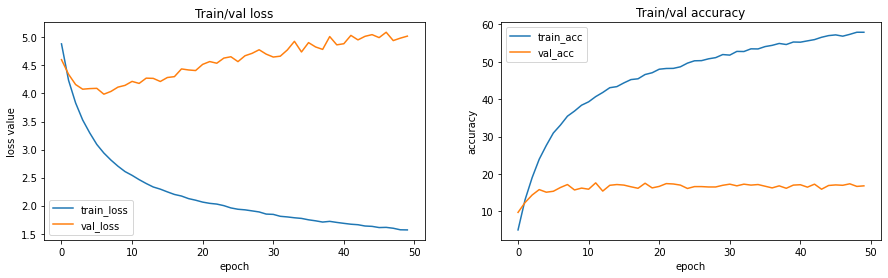

Best Epoch: 12 Average loss: 4.179365172982216 Accuracy: 17.6
CPU times: user 3min 8s, sys: 1min 11s, total: 4min 20s
Wall time: 20min 29s


In [16]:
%%time
model = ConvNet()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("random_features_finetuned", train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_dataloader, val_dataloader)

## Task 5. Competition time!
Read the images from "data/test" folder. There are no labels for these images. Run your best model (from Task 4) on these images and save the image IDs (names) and predicted label in a file LastName.csv. You will receive a link via email to upload the CSV file to  an online system which will give you the score of your model on the held-out test set. Top 5 students will obtain bonus points.

***Provide a short description of the model you used for the Kaggle submission.***

In [20]:
paths = []
ids = []
for dirname, _, filenames in os.walk(path_test_unlabelled):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        ids.append(filename.split('.')[0])


_model = ConvNet()
_model = _model.to(device)
_model.load_state_dict(torch.load("random_features_fixed_20200518_1745.pht"))

m_loss, accuracy = test(_model, val_dataloader, loss_fn)
print("Average loss:", m_loss, "Accuracy:", accuracy)
time.sleep(0.250) # needed for tqdm

def _predict(path):
    """Returns a randomn prediction"""
    _img = Image.open(path)
    _img = _transforms_val(_img)

    _img = _img.unsqueeze(0)
    _img = _img.to(device)
    output = _model(_img)
    _, preds = torch.max(output, 1)

    return preds[0].cpu().detach().numpy()

predictions = []

for path in tqdm(paths):
    prediction = _predict(path)
    predictions.append(prediction)           

with open('test_results.csv', 'w') as f:
    f.write('id,label\n')
    for id, pred in zip(ids, predictions):
        f.write(f'{id},{pred}\n')

Average loss: 4.390562474727631 Accuracy: 18.85


100%|██████████| 10000/10000 [00:17<00:00, 578.28it/s]


In [0]:
# !cp '/content/finetuned_features.pht' '/content/drive/My Drive/ATML/Assignments/Assignment3/'
# !cp '/content/fixed_features.pht' '/content/drive/My Drive/ATML/Assignments/Assignment3/'
# !cp '/content/random_features_finetuned.pht' '/content/drive/My Drive/ATML/Assignments/Assignment3/'
# !cp '/content/random_features_fixed.pht' '/content/drive/My Drive/ATML/Assignments/Assignment3/'
# !cp '/content/test_results.csv' '/content/drive/My Drive/ATML/Assignments/Assignment3/'
# !cp '/content/unsuperviced_pre-training.pht' '/content/drive/My Drive/ATML/Assignments/Assignment3/'

!cp 'random_features_fixed_20200518_1745.pht' '/content/drive/My Drive/ATML/Assignments/Assignment3/'